# El *Hello World!* del Tiny Machine Learning

Se le conoce como *Hello World!* (en español *¡Hola Mundo!*) a un programa que se utiliza como introducción al estudio en un lenguaje o paradigma de programación.

En el caso del Tiny Machine Learning, el programa que consideramos como el introductorio, ya que se utilizan herramientas muy básicas como una red neuronal por capas sencilla, es la creación, implementación y prueba de un modelo que prediga una función seno.

Y a continuación se redacta paso a paso como se crea un conjunto de datos que siguen una función seno, su división en conjuntos de entrenamiento, prueba y validación, la creación y entrenamiento de la red neuronal y la compresión a un modelo de TensorFlowLite para implementarlo en un microcontrolador Arduino Nano Ble 33.

## El primer paso, las librerías

Como todo buen programa, necesitamos una serie de librerias iniciales que permitan la correcta ejecución e implementación de nuestro algoritmo. En este caso contamos con 5 librerías cuyo uso describimos aquí:

- **Numpy**: Es una biblioteca que da soporte para crear vectores y matrices grandes multidimensionales, junto con una gran colección de funciones matemáticas de alto nivel para operar con ellas.
- **Matplotlib**: Es una librería para la generación de gráficos en dos dimensiones, a partir de datos.
- **Math**: Un módilo que permite el acceso a funciones matemáticas definidas.
-**Tensorflow**: Biblioteca de código abierto para aprendizaje automático a través de un rango de tareas desarrollado por Google.
-**Keras**: Librería de Redes Neuronales de Código Abierto especialmente diseñada para posibilitar la experimentación en más o menos poco tiempo con redes de Aprendizaje Profundo.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import layers

## Preparando los datos

Ya que queremos un modelo que pueda predecir una función seno, lo primero que debemos hacer es crear una función seno a partir de una cantidad finita de datos en el plano cartesiano *x-y* cuya distribución asemeje bastante a una función seno.

Aquí veremos un poco como es que para un modelo de mejor o peor presición de predicción, la cantidad de datos con los que ese modelo sea entrenado debe ser bastante amplio.

El siguiente bloque de código genera de manera aleatoria una serie de $1000$ puntos que usaremos como valores de x, estos estarán distribuidos en un rango de $0$ a $2\pi$ y después, para agregar más aleatoriedad a esa distribución, hacemos que se cambien de orden aleatoriamente.

In [2]:
SAMPLES = 1000
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

In [ ]:
x_values

In [ ]:
np.random.shuffle(x_values)

In [ ]:
x_values

Tras esto, le daremos todos esos 1000 datos a una función que los toma y te devuelve la evaluación de ese valor en una función seno, $y=\sin(x)$ y con la biblioteca matplotlib mostramos dicha función:

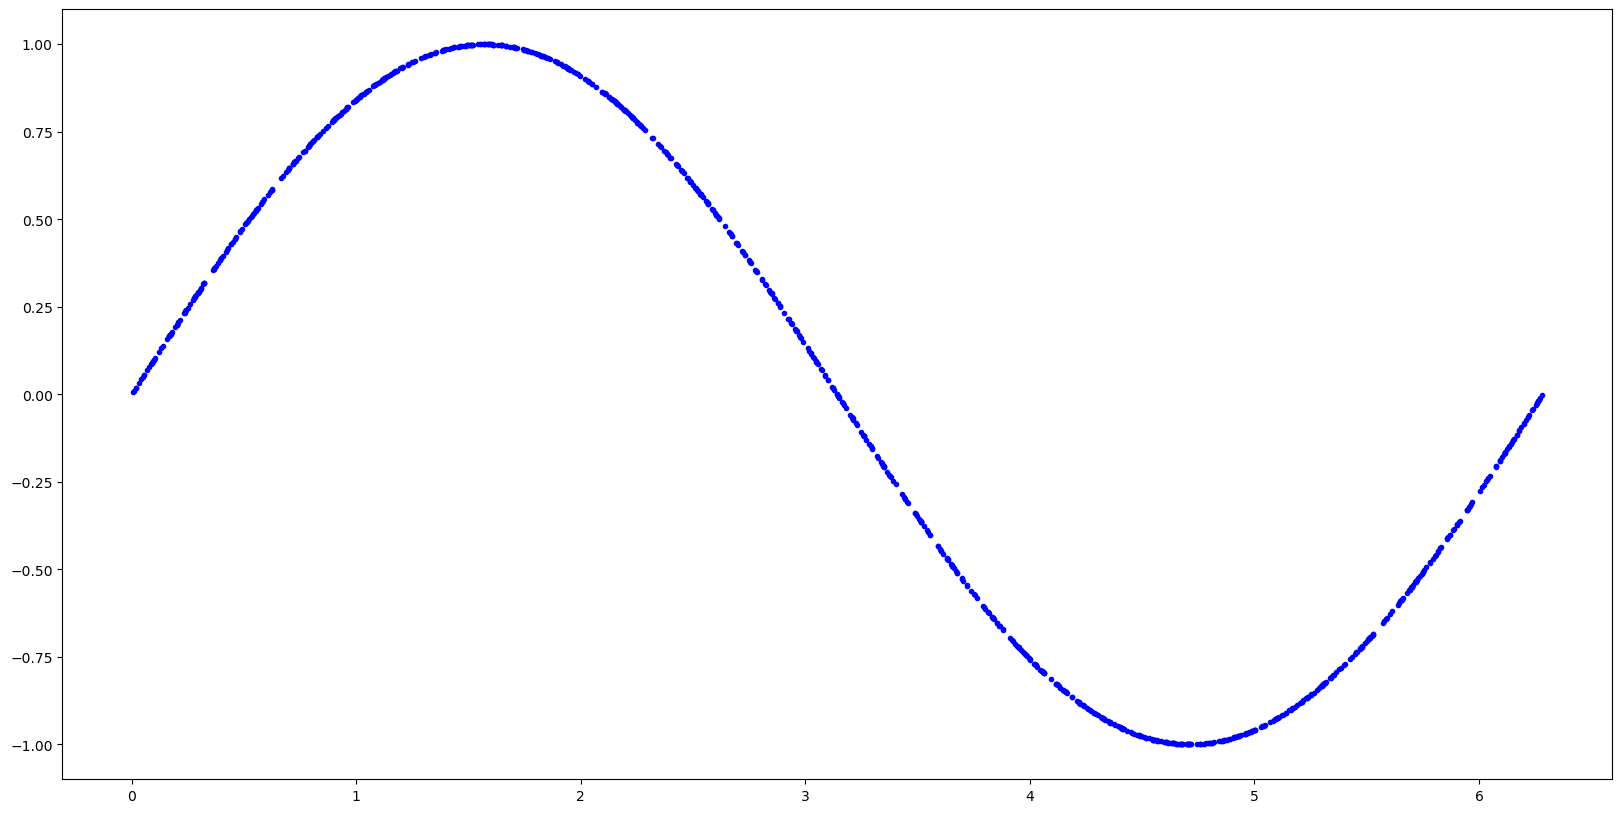

In [3]:
y_values_orig = np.sin(x_values)
plt.figure(figsize=(20,10))
plt.plot(x_values, y_values_orig, 'b.')
plt.show()

Ya que los datos están perfectamente ubicados en una función seno (algo que en datos reales es dificil, muy dificil, que obtengamos) lo que haremos será desplazar un poco esos datos para que todos se localizen alrededor de la función seno:

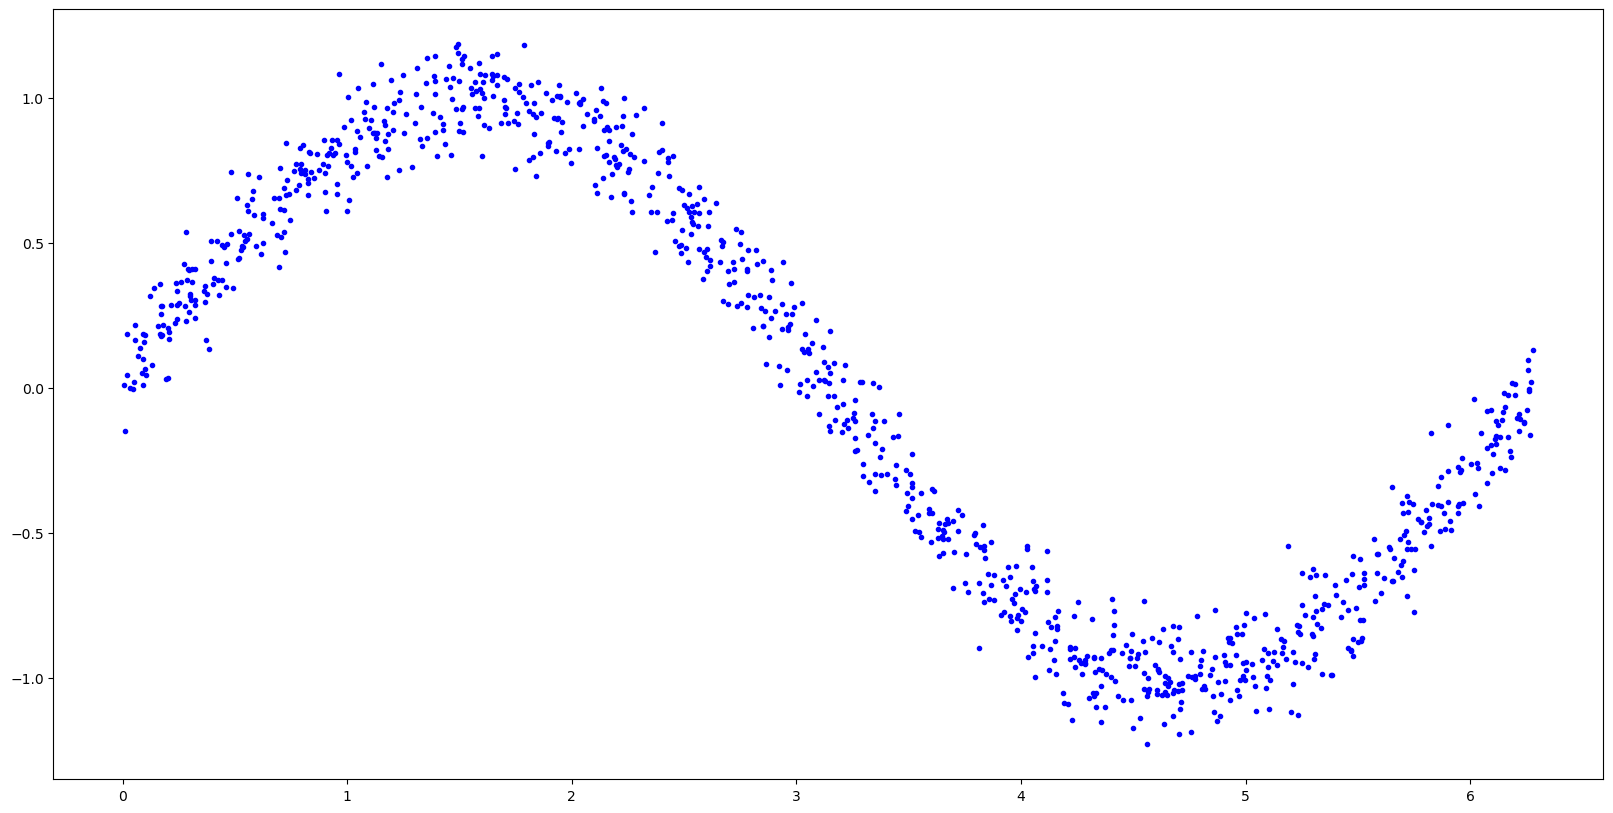

In [4]:
y_values = np.sin(x_values)
y_values += 0.1*np.random.randn(*y_values.shape)
plt.figure(figsize=(20,10))
plt.plot(x_values, y_values, 'b.')

podemos observar que los datos que tengo en el eje $y$ son la misma cantidad que en $x$ con:

In [5]:
y_values.shape

(1000,)

Podemos ver una gráfica comparativa a continuación, si graficamos los valores desplazados y los originales:

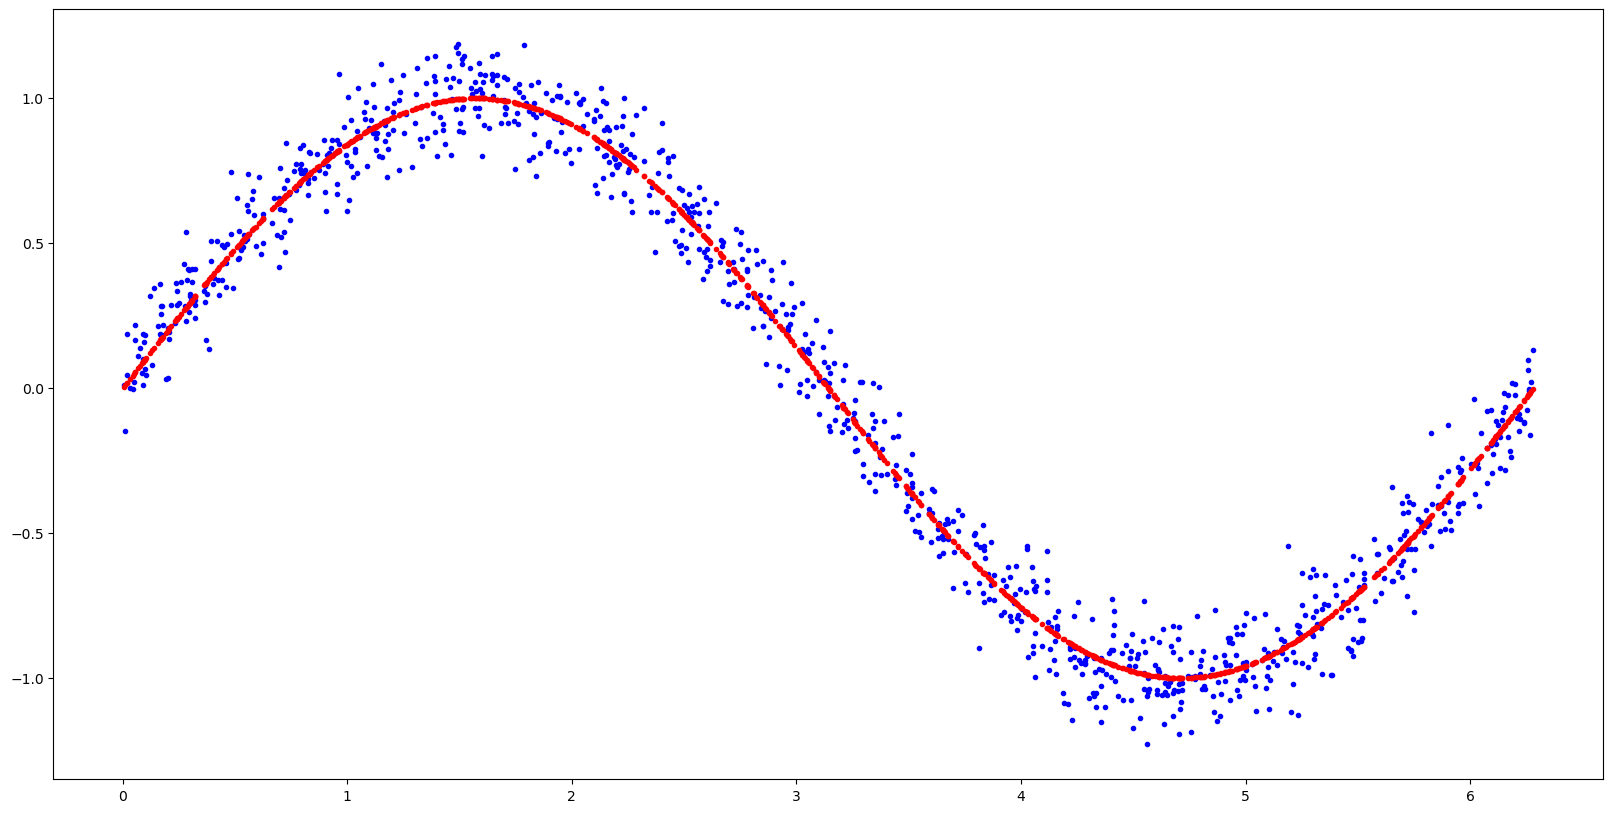

In [7]:
plt.figure(figsize=(20,10))
plt.plot(x_values, y_values, 'b.')
plt.plot(x_values, y_values_orig, 'r.')
plt.show()

### Dividiendo los datos

A la hora de entrenar un modelo de machine learning, lo ideal es que, de todos los datos, se entrenase al modelo con menos de la cantidad original, esto para poder, una vez que nuestro modelo ha sido entrenado, probar con datos ajenos que en verdad este funcionando, y su precisión, comparando el valor real contra lo que el algoritmo nos predice.

Es por ello que vamos a dividir nuestros datos en 3 conjunos, **Entrenamiento**, **Validación** y **Prueba** tal que obtengamos 600, 200 y 200 respectivamente mediante una función de la librería *numpy.split*:

In [8]:
TRAIN_SPLIT = int(0.6*SAMPLES)
TEST_SPLIT = int(0.2*SAMPLES+TRAIN_SPLIT)

x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

Cada uno de estos conjuntos los podemos visualizar por separado:

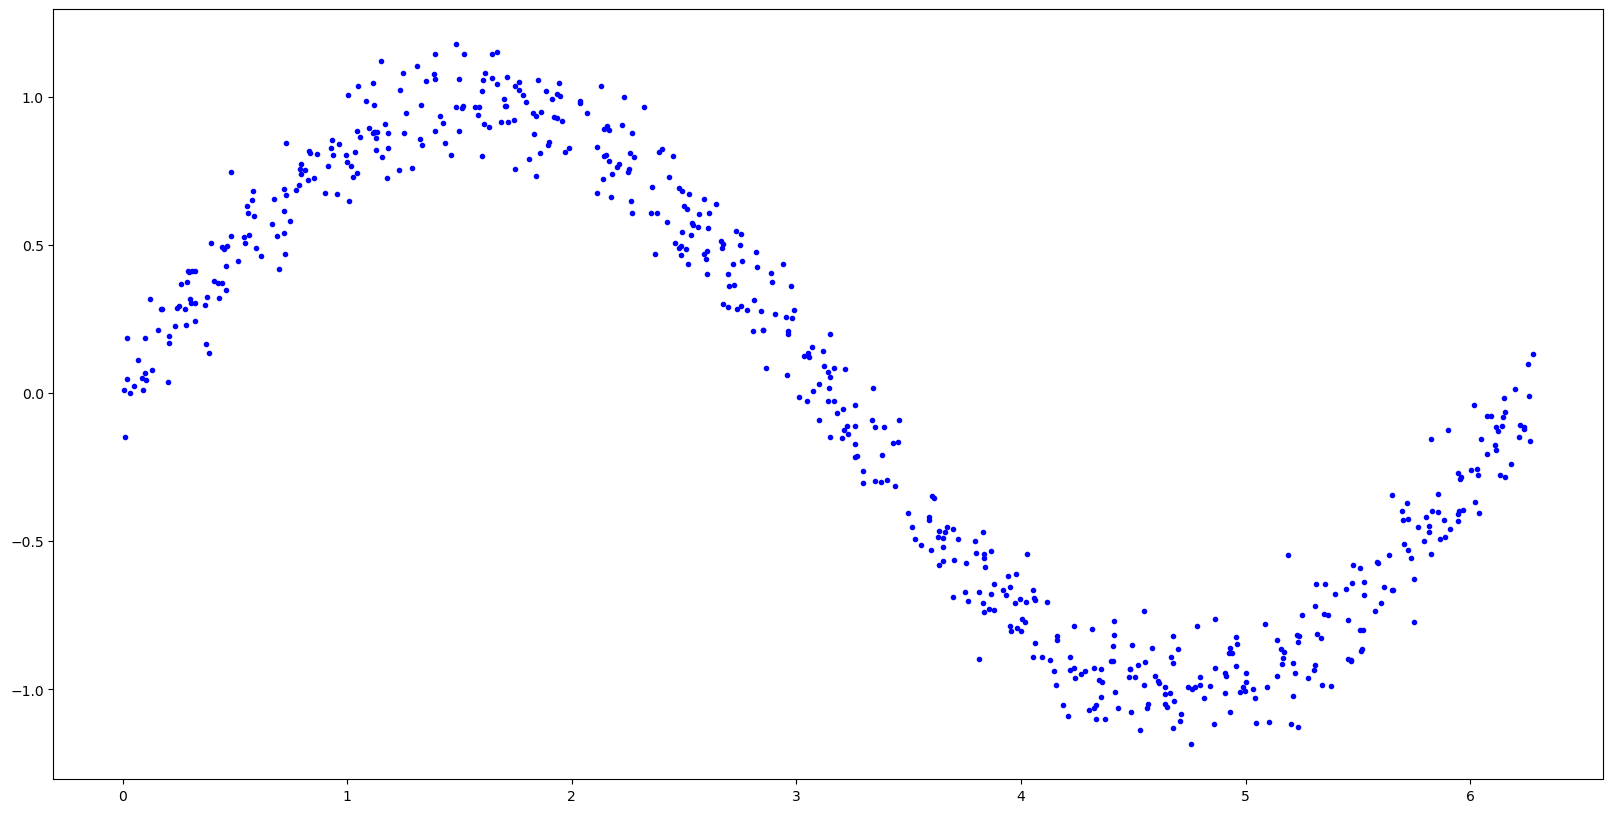

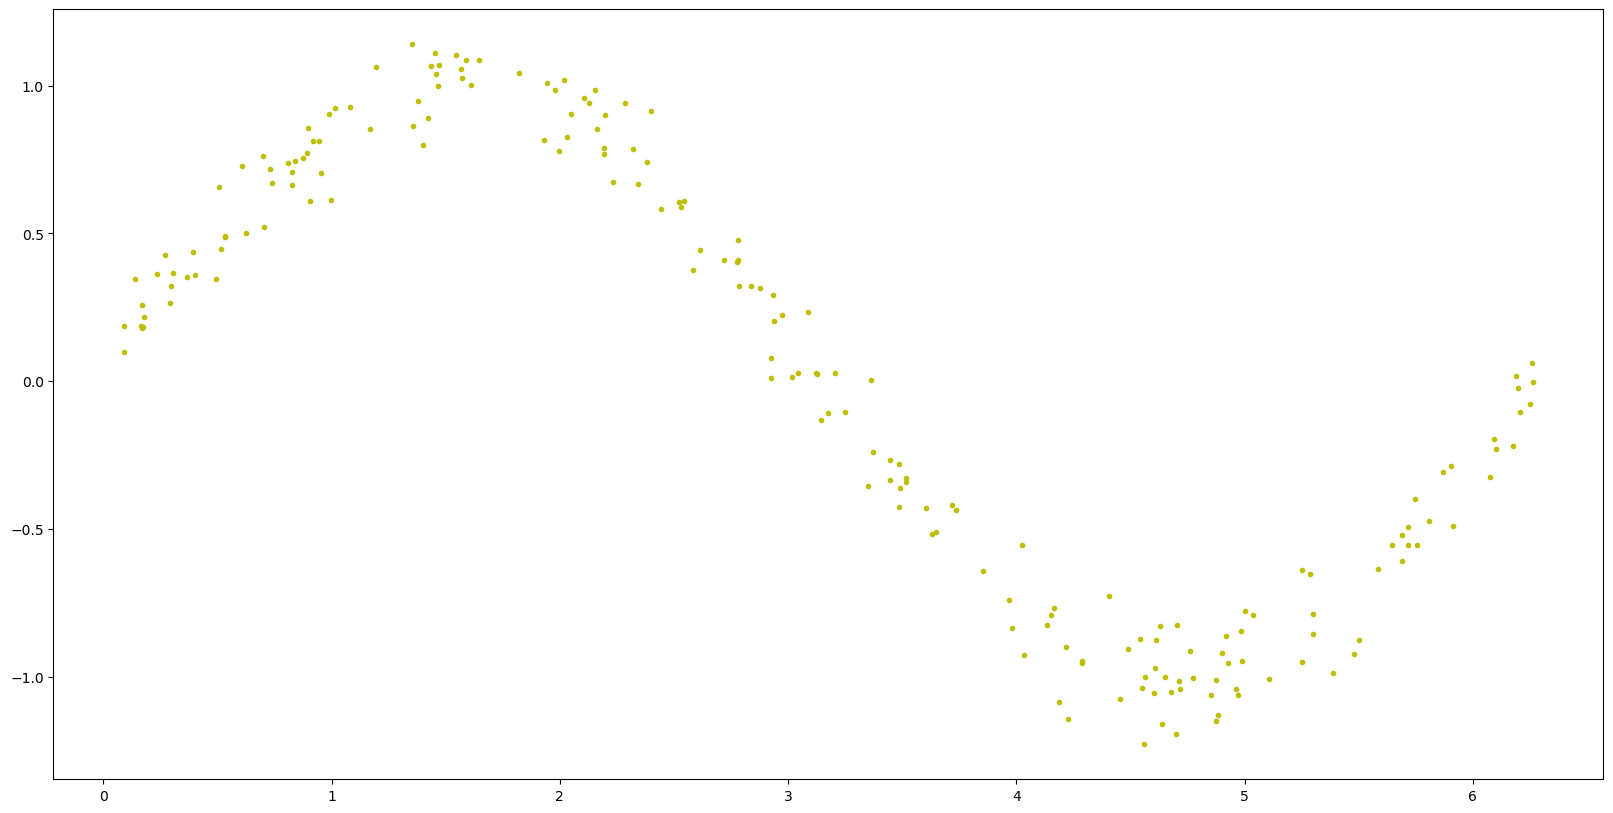

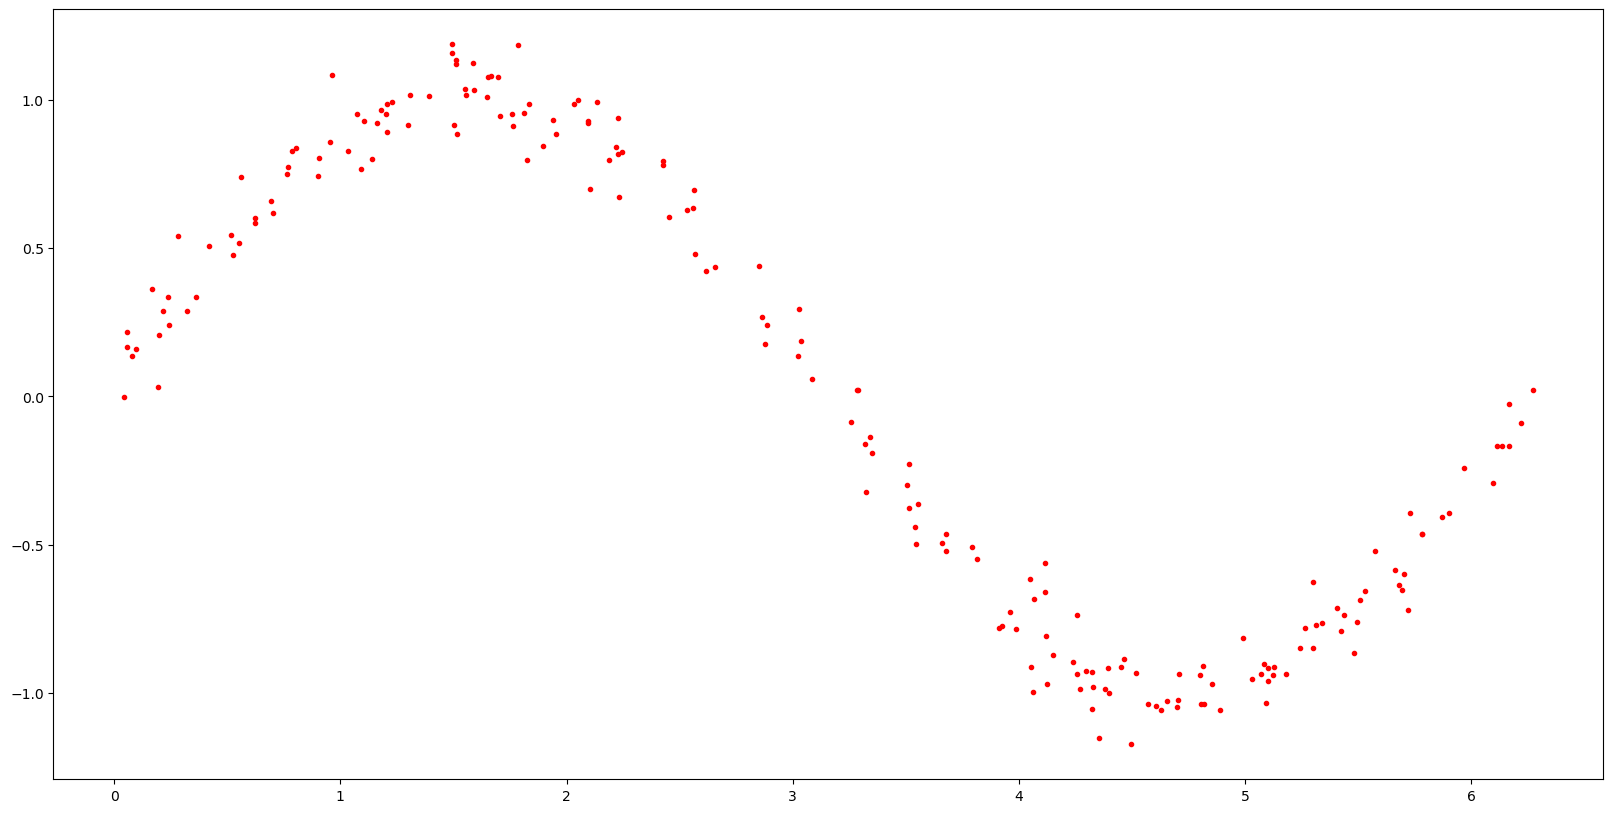

In [9]:
plt.figure(figsize=(20,10))
plt.plot(x_train, y_train, 'b.', label = 'Train')
plt.figure(figsize=(20,10))
plt.plot(x_validate, y_validate, 'y.', label = 'Validate')
plt.figure(figsize=(20,10))
plt.plot(x_test, y_test, 'r.', label = 'Test')

o juntos nuevamente pero distinguiendose:

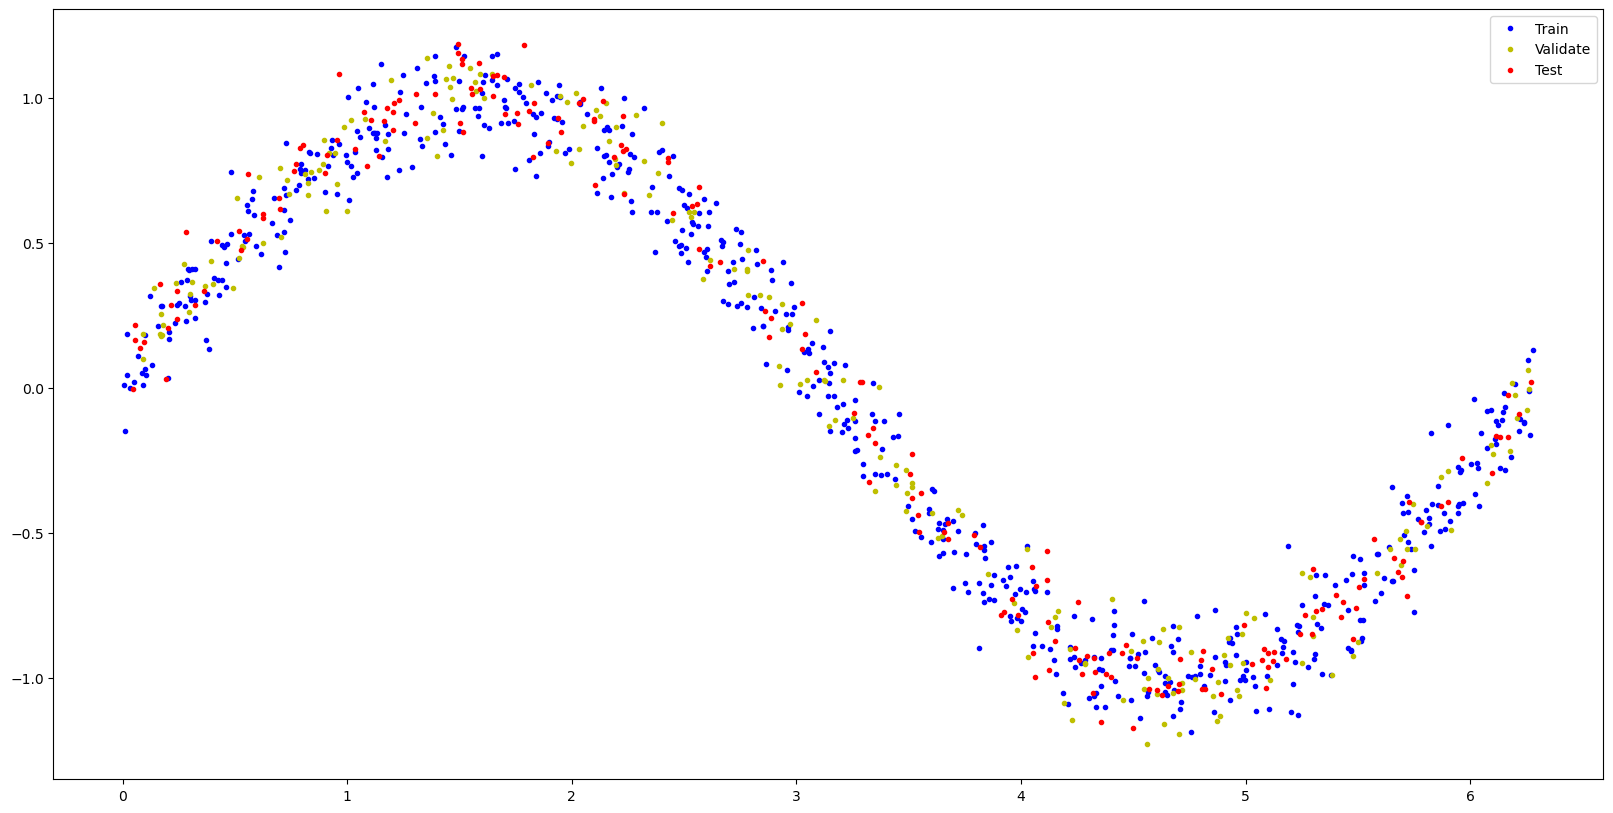

In [10]:
plt.figure(figsize=(20,10))
plt.plot(x_train, y_train, 'b.', label = 'Train')
plt.plot(x_validate, y_validate, 'y.', label = 'Validate')
plt.plot(x_test, y_test, 'r.', label = 'Test')
plt.legend()
plt.show()

Otra manera de dividir los datos es "cortando" las listas de números de la siguiente manera:

In [11]:
x_train_1 = x_values[:TRAIN_SPLIT]
x_validate_1 = x_values[TRAIN_SPLIT:TEST_SPLIT]
x_test_1 = x_values[TEST_SPLIT:]

print(x_train_1.size, x_validate_1.size, x_test_1.size)

y_train_1 = y_values[:TRAIN_SPLIT]
y_validate_1 = y_values[TRAIN_SPLIT:TEST_SPLIT]
y_test_1 = y_values[TEST_SPLIT:]

600 200 200


Y podemos comprobar que hacen lo mismo si vemos la gráfica que se genera:

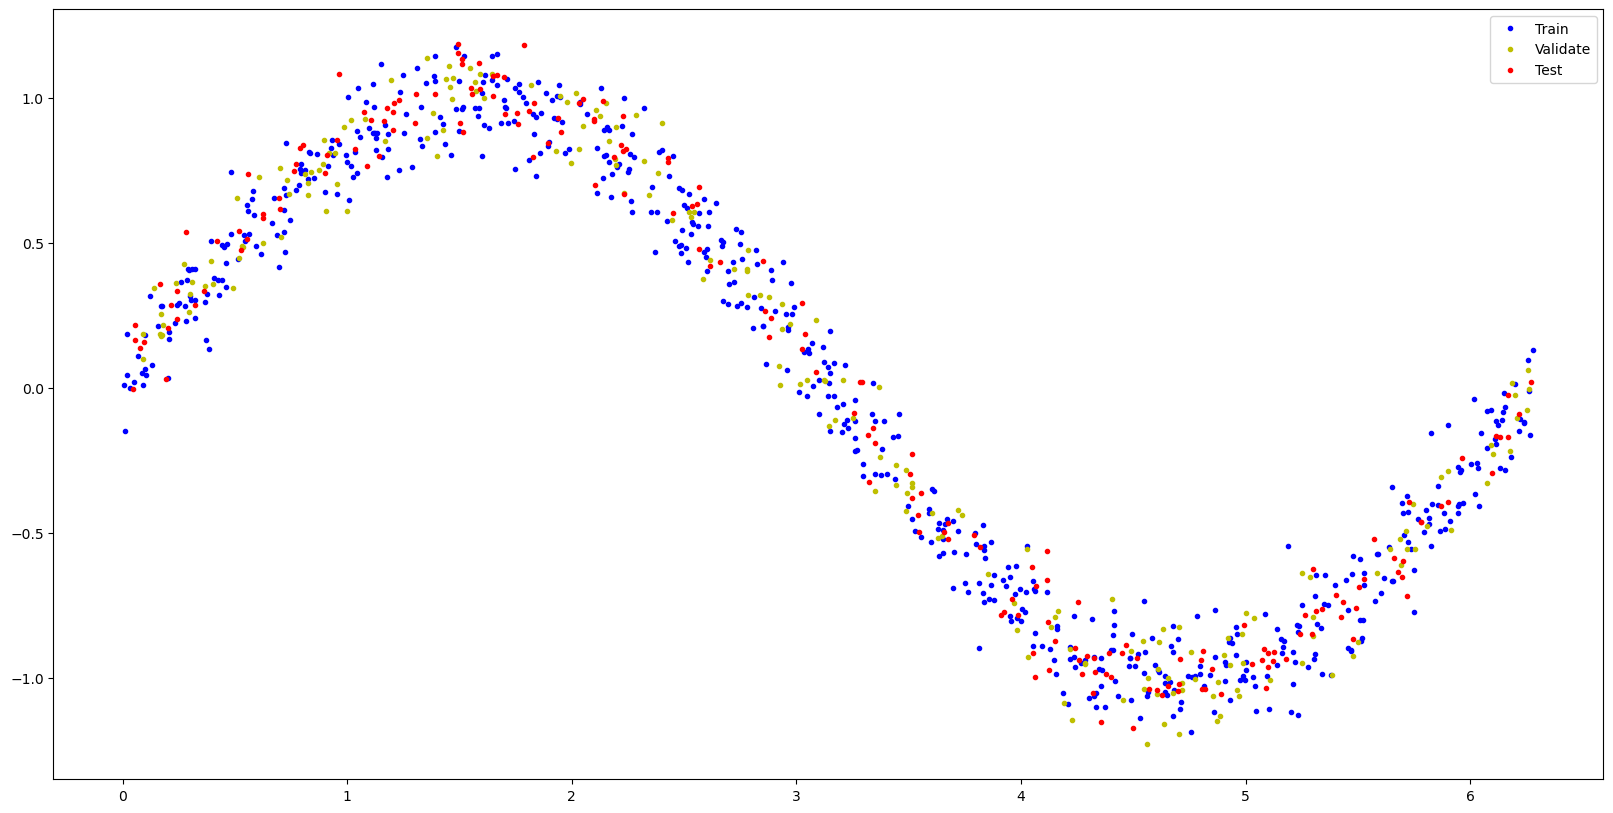

In [12]:
plt.figure(figsize=(20,10))
plt.plot(x_train_1, y_train_1, 'b.', label = 'Train')
plt.plot(x_validate_1, y_validate_1, 'y.', label = 'Validate')
plt.plot(x_test_1, y_test_1, 'r.', label = 'Test')
plt.legend()
plt.show()

## Diseñando el Modelo 1

Ya que tenemos nuestros datos, lo que nos compeete es crear esa red neuronal de la que hablabamos, capaz de aproximar una función seno.

- Para comenzar, definimos algo conocido como **épocas** (Epochs) que son un parámetro que le dirá a nuestro modelo cuantas veces probara los datos y se actualizará.
- Otro parámetro importante es el **tamaño de lote** (batch_size) el cuál nos dice cuántos datos vamos a probar por cada vez que entrenemos a nuestra red neuronal.
- También es importante conocer lo que es una **Capa densa** (layer.Dense) cuya definición es parte de lo que es una red neuronal y para entenderla de manera simple, son las neuronas ordenadas que reciben los datos del lote y suman sus valores con diferente "intensidad" y lo pasan a la siguiente capa, y esto lo repiten por la cantidad de épocas.

Con esto explicado brevemente, este es un primer modelo de 16 neuronas de entrada y una sola de salida (ya que solo necesitamos que el modelo nos diga una posición en $y$):

In [13]:
EPOCHS=1000

sine_model = tf.keras.Sequential()
sine_model.add(layers.Dense(16, activation = 'relu', input_shape=(1,)))
sine_model.add(layers.Dense(1))
sine_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

sine_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 49 (196.00 Byte)
Trainable params: 49 (196.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Como vemos, se nos escribe la cantidad de neuronas por capa, 16 en la primera y 1 en la segunda. Así pues, la cantidad de parámetros que esta red tendra que tomar y mejorar son 49 ($16+16+16\times1+1$) y así sin más, lo dejamos que aprenda, dandole los valores para entrenarlo y para validarlo de la siguiente manera:

In [14]:
history=sine_model.fit(x_train, y_train, epochs=EPOCHS, batch_size=16, validation_data=(x_validate, y_validate))

Epoch 1/1000
38/38 [==============================] - 1s 14ms/step - loss: 2.7056 - mae: 1.3206 - val_loss: 1.9581 - val_mae: 1.1619
Epoch 2/1000
38/38 [==============================] - 0s 5ms/step - loss: 1.5063 - mae: 1.0448 - val_loss: 1.1448 - val_mae: 0.9462
Epoch 3/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.9045 - mae: 0.8571 - val_loss: 0.7626 - val_mae: 0.7973
Epoch 4/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.6286 - mae: 0.7202 - val_loss: 0.5986 - val_mae: 0.6932
Epoch 5/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.5295 - mae: 0.6435 - val_loss: 0.5314 - val_mae: 0.6410
Epoch 6/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.4790 - mae: 0.6046 - val_loss: 0.4919 - val_mae: 0.6106
Epoch 7/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.4458 - mae: 0.5779 - val_loss: 0.4597 - val_mae: 0.5940
Epoch 8/1000
38/38 [==============================] - 0s 4ms/step - loss: 0

Una vez entrenado, hay ciertos valores que nos interesan para conocer la eficacia del modelo, esos son *training_loss* y *validation_loss* los cuales significan cuantos fallos en porcentaje, tiene nuestro modelo al probarlo con valores de entrenamiento y cuantos con valores de validación. Es decir, con valores ya conocidos y con valores desconocidos para el modelo.

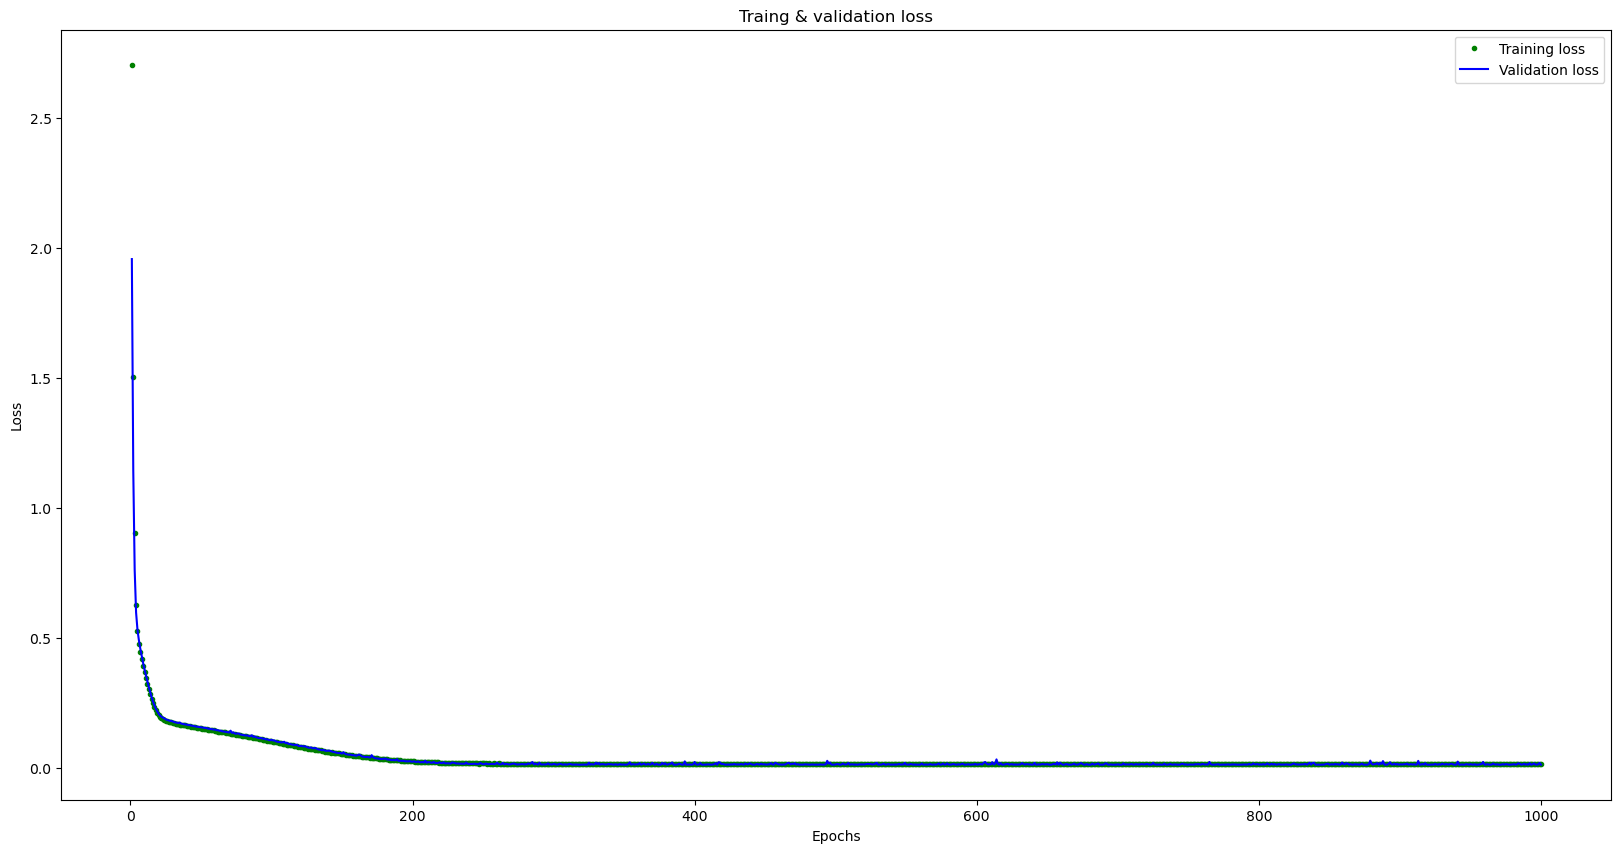

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Traing & validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Podemos ver como al principio había un error enorme de errores, pero bajan rápidamente hasta que realmente pasadas las 200 épocas nuestro modelo no mejorá casi nada su eficacia. Para mostrar de mejor manera esto, vamos a cortar los primeros 200 valores de la anterior gráfica, para poder apreciar de mejor manera los puntos cercanos al 0.

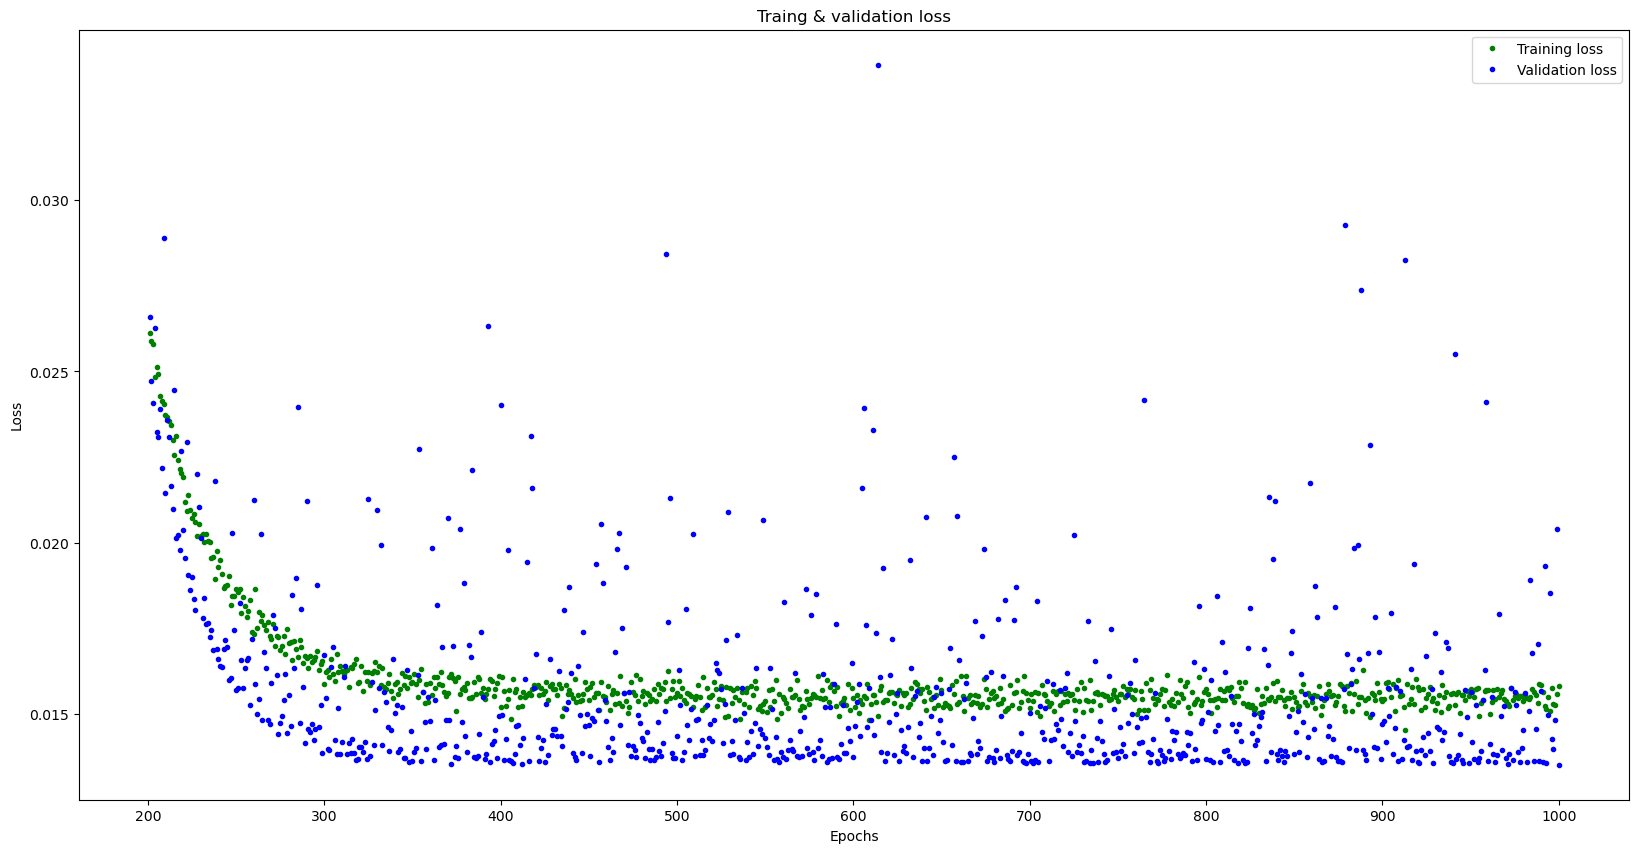

In [17]:
SKIP = 200
plt.figure(figsize=(20,10))
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title("Traing & validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Y bien, finalmente, tenemos un conjunto de 200 datos que aún no han pasado por nuestro modelo, los datos de prueba, los cuales usaremos para mostrar qué tan efectivo es nuestro modelo con datos completamente desconocidos.

7/7 [==============================] - 0s 2ms/step


<Figure size 640x480 with 0 Axes>

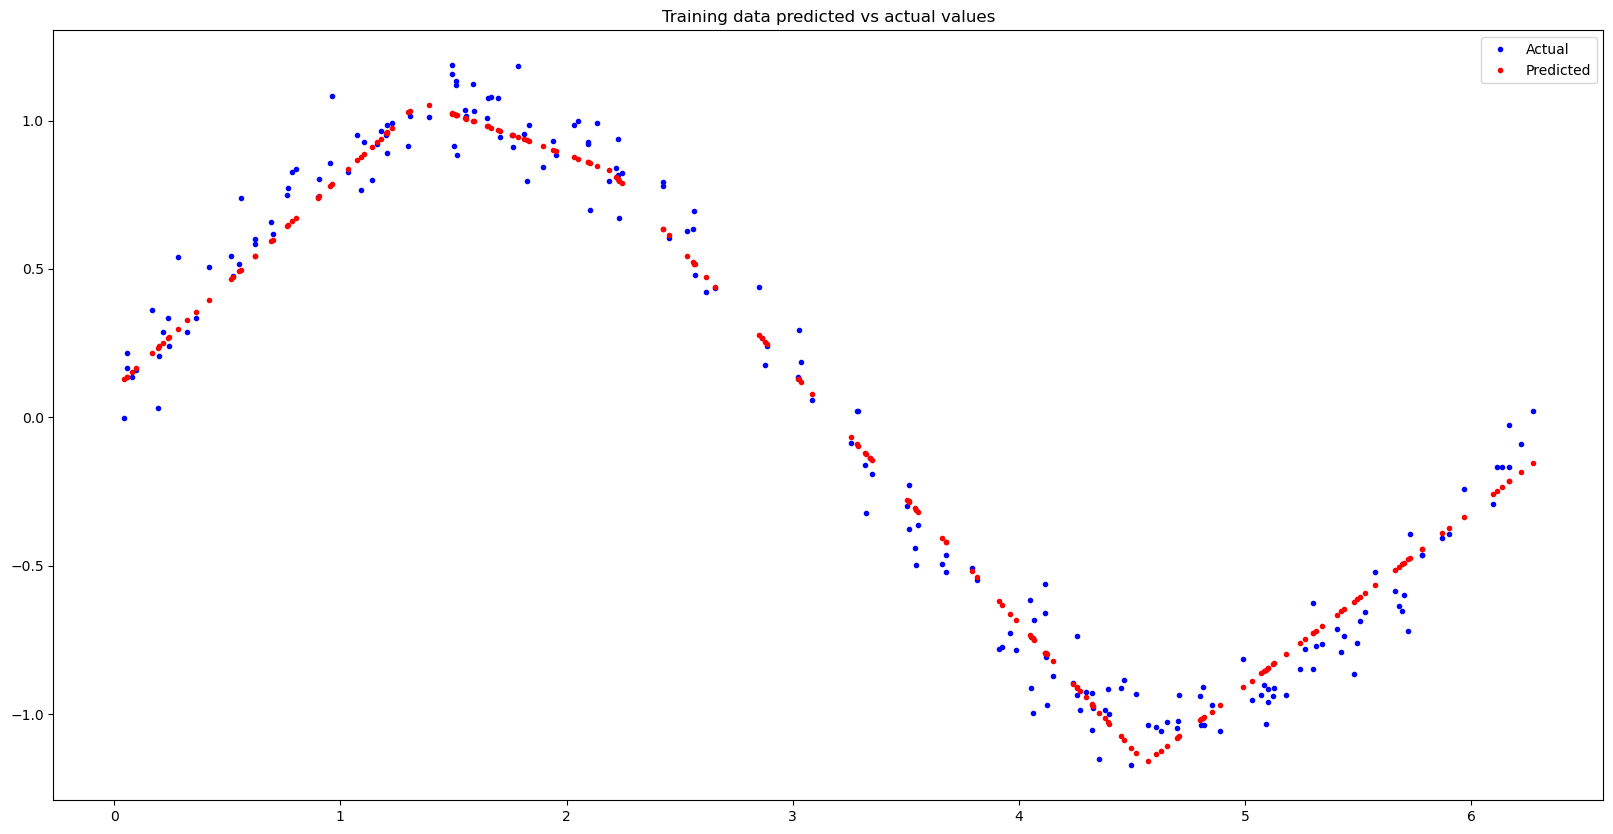

In [18]:
predictions = sine_model.predict(x_test)

plt.clf()
plt.figure(figsize=(20,10))
plt.title('Training data predicted vs actual values')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

Podemos ver fácilmente que este modelo no parece replicar muy bien una función seno a partir de estos datos, es normal, su presisión ante datos nuevos oscila bastante, parece que necesitamos otra estructura para mejorar esto.

## Diseñando el Modelo 2

Como ya conocemos las variables y conceptos importantes, pasemos a lo más importante de este modelo 2, agregaremos una segunda capa densa, de también 16 neuronas, justo después de la primera tal que:

In [19]:
sine_model_2 = tf.keras.Sequential()
sine_model_2.add(layers.Dense(16, activation = 'relu', input_shape=(1,)))
sine_model_2.add(layers.Dense(16, activation = 'relu'))
sine_model_2.add(layers.Dense(1))
sine_model_2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

sine_model_2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                32        
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Notemos que pasamos de tener 49 parámetros a 321 parámetros, este aumento de complejudad nos debería proporcionar una mayor precisión en nuestro modelo, ¿No? así que intentemos entrenarlo con él.

In [20]:
history=sine_model_2.fit(x_train, y_train, epochs=EPOCHS, batch_size=16, validation_data=(x_validate, y_validate))

Epoch 1/1000
38/38 [==============================] - 1s 8ms/step - loss: 0.6550 - mae: 0.6732 - val_loss: 0.3716 - val_mae: 0.5234
Epoch 2/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.3269 - mae: 0.4980 - val_loss: 0.3233 - val_mae: 0.4863
Epoch 3/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.2794 - mae: 0.4618 - val_loss: 0.2733 - val_mae: 0.4518
Epoch 4/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.2402 - mae: 0.4285 - val_loss: 0.2297 - val_mae: 0.4133
Epoch 5/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.2037 - mae: 0.3955 - val_loss: 0.1973 - val_mae: 0.3825
Epoch 6/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.1831 - mae: 0.3730 - val_loss: 0.1864 - val_mae: 0.3653
Epoch 7/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.1739 - mae: 0.3604 - val_loss: 0.1799 - val_mae: 0.3653
Epoch 8/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.

Grafiquemos nuevamente las pérdidas para ver mejor el cambio:

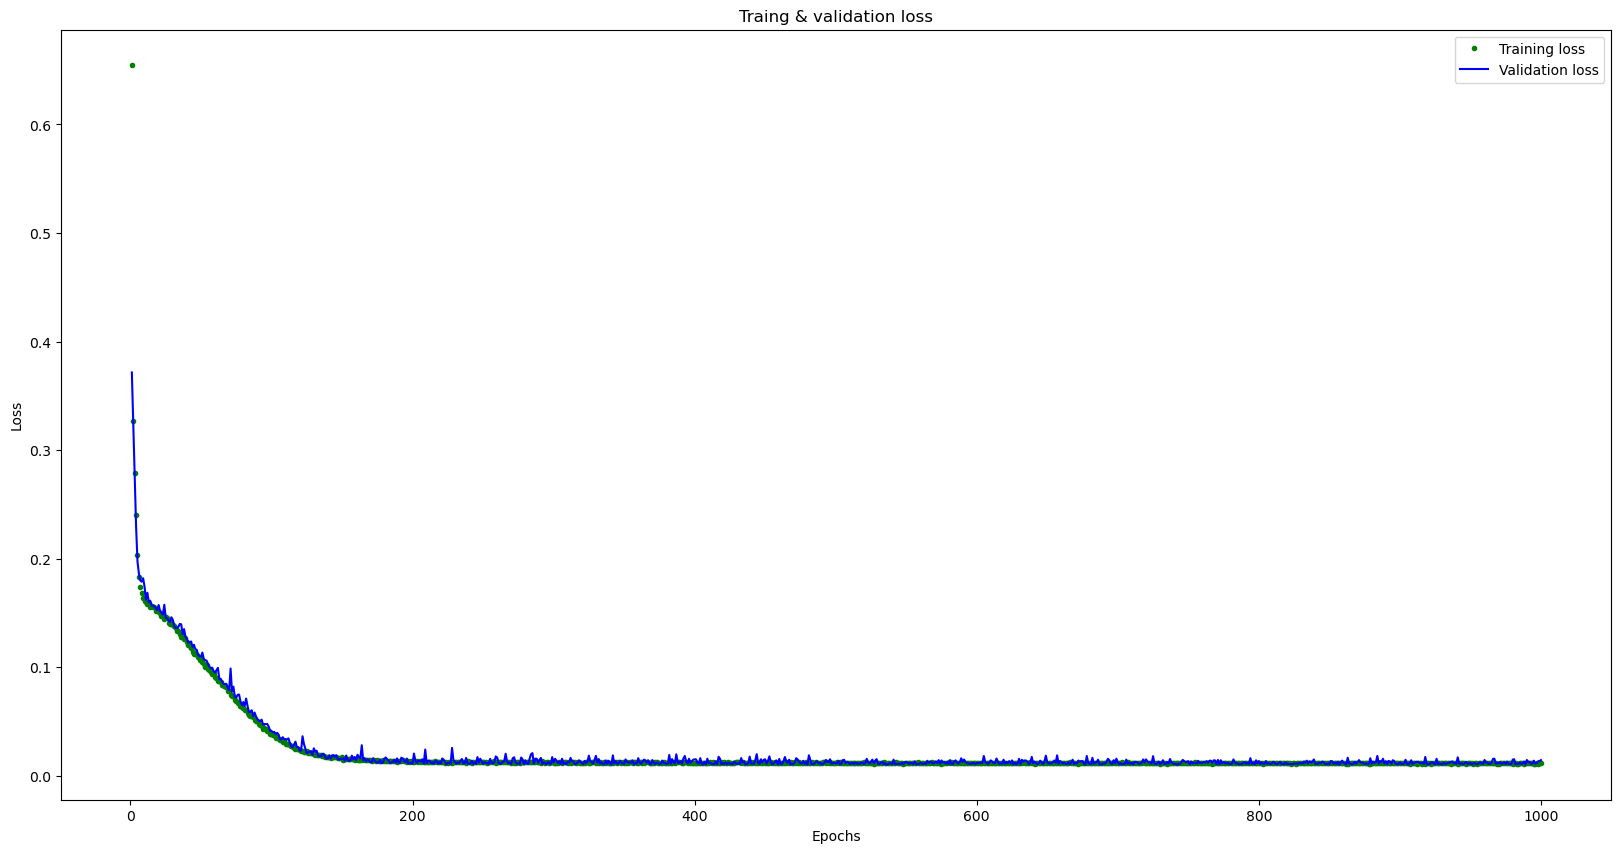

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Traing & validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Y nuevamente cortemos para ver más a detalle

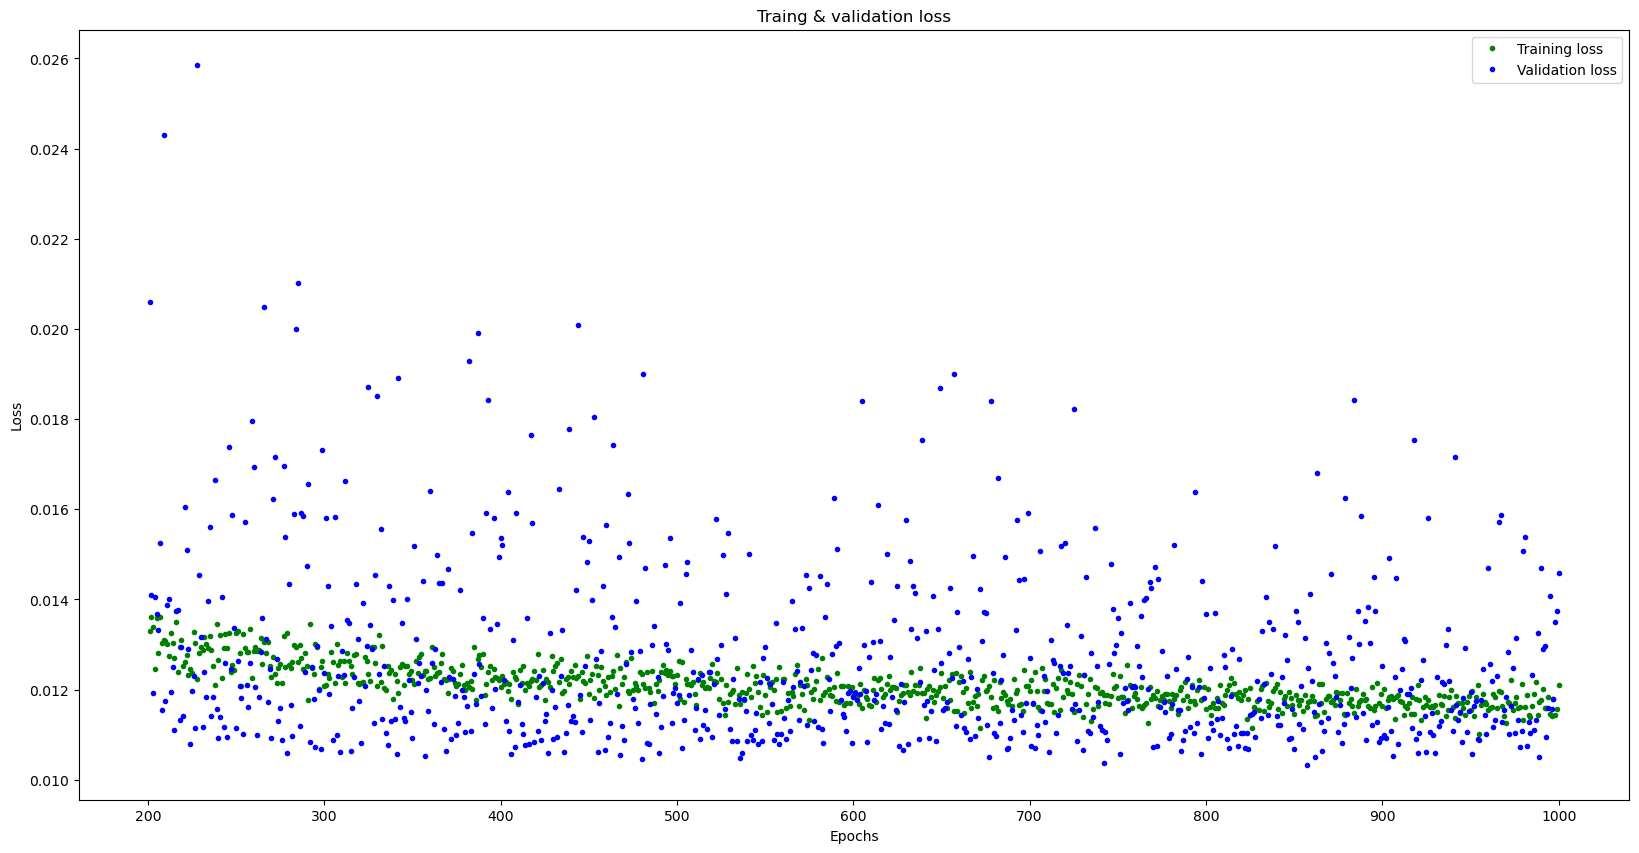

In [22]:
plt.figure(figsize=(20,10))
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title("Traing & validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Pareciera que tenemos una línea verde más "consistente" por llamarla de alguna manera, además de que los puntos azules no son tan altos si consideramos la escala de la izquierda, pero la mejor manera de verlo es mostrando como predice nuestro nuevo modelo, datos nuevos:

7/7 [==============================] - 0s 2ms/step


<Figure size 640x480 with 0 Axes>

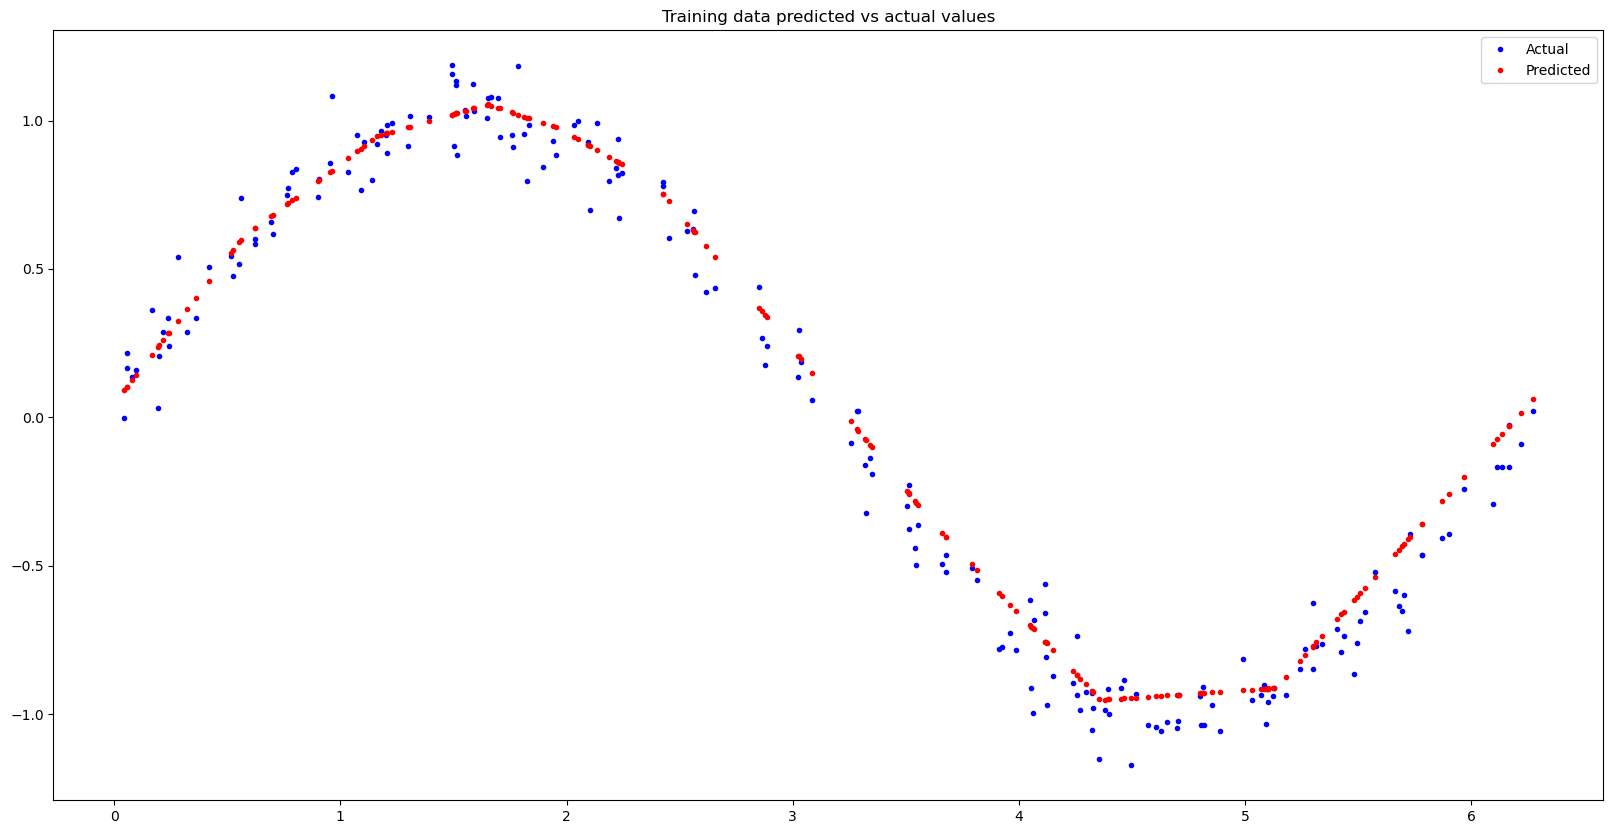

In [23]:
predictions = sine_model_2.predict(x_test)

plt.clf()
plt.figure(figsize=(20,10))
plt.title('Training data predicted vs actual values')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

El modelo mejoró bastante el ajuste que tenemos de la función seno, ya es algo que si podemos considerar para una aproximación senoidal

## Implementando nuestro modelo

Bien, ya entrenamos una red de neuronal para que, si le pasamos una cantidad de puntos, nos aproxime una función seno, ¿cuál es el siguiente paso? pues vamos a probar pasarle este modelo a nuestro Arduino Nano BLE 33 y ver si un aparato tan pequeño es capaz de procesar todos estos datos para generar una aproximación igual de buena.

Para esto vamos a **convertir** nuestro modelo en algo que el arduino "entienda" (ya que no, éste no procesa python).

El método está incluido en la librería de TensorFlow y se llama **TensorFlowLite**, nosotros creamos un objeto convertidor, en el que le pasamos nuestro modelo, y le pedimos que lo convierta de la siguiente manera:

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(sine_model_2)
tflite_model = converter.convert()
open("sine_model_2.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Oswal\AppData\Local\Temp\tmpm3sosy1v\assets


INFO:tensorflow:Assets written to: C:\Users\Oswal\AppData\Local\Temp\tmpm3sosy1v\assets


3192

Después, pasamos a traves de unos pasos en los que simplemente el modelo convertido necesita pasar, y junto a esto nos permite ver algunos parámetros como los valores de entrada y de salida de nuestro modelo:

In [26]:
sine_model_2 = tf.lite.Interpreter('sine_model_2.tflite')
sine_model_2.allocate_tensors()

In [27]:
sine_model_2.get_input_details()

[{'name': 'serving_default_dense_2_input:0',
  'index': 0,
  'shape': array([1, 1]),
  'shape_signature': array([-1,  1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [28]:
sine_model_2.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 9,
  'shape': array([1, 1]),
  'shape_signature': array([-1,  1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [30]:
sine_model_input_index = sine_model_2.get_input_details()[0]['index']
sine_model_output_index = sine_model_2.get_output_details()[0]['index']

Probamos nuevamente con una serie de datos, el modelo así como el arduino **debería** de estar procesandolo:

In [31]:
sine_model_predictions = []
i=0
for x_value in x_test :
  x_value_tensor = tf.convert_to_tensor([[x_value]], dtype=np.float32)
  sine_model_2.set_tensor(sine_model_input_index, x_value_tensor)
  sine_model_2.invoke()
  sine_model_predictions.append(sine_model_2.get_tensor(sine_model_output_index)[0])
  print(i, sine_model_predictions[i])
  i += 1

0 [0.914289]
1 [0.21132156]
2 [-0.6530439]
3 [0.12464524]
4 [-0.77219117]
5 [0.95777243]
6 [0.14854836]
7 [-0.07657675]
8 [0.09086177]
9 [-0.25778687]
10 [-0.6806844]
11 [0.63100487]
12 [0.97931296]
13 [0.65285903]
14 [0.5777599]
15 [-0.9394874]
16 [0.8648772]
17 [-0.05683277]
18 [-0.7110413]
19 [0.01558789]
20 [1.0222551]
21 [-0.9451962]
22 [-0.92053527]
23 [-0.65439355]
24 [-0.94769025]
25 [-0.40390295]
26 [1.0543483]
27 [-0.24961649]
28 [-0.07458232]
29 [0.9451497]
30 [1.0243133]
31 [-0.02858572]
32 [1.0202372]
33 [-0.85580313]
34 [0.91740835]
35 [0.6816741]
36 [0.67751646]
37 [-0.09023602]
38 [1.0327158]
39 [0.97824025]
40 [0.74054986]
41 [-0.8733193]
42 [-0.75628227]
43 [-0.9136588]
44 [0.36940995]
45 [1.007951]
46 [0.6238063]
47 [1.0335294]
48 [-0.40268317]
49 [-0.42732674]
50 [-0.9283887]
51 [-0.737143]
52 [0.82628006]
53 [1.0538847]
54 [0.9979476]
55 [0.24491854]
56 [0.63667613]
57 [1.0424193]
58 [-0.5158586]
59 [0.9569885]
60 [0.9514698]
61 [1.0272832]
62 [1.0412375]
63 [1.020

Y los graficamos para observar la comparación entre las predicciones hechas con el modelo completo y el modelo convertido:

<Figure size 640x480 with 0 Axes>

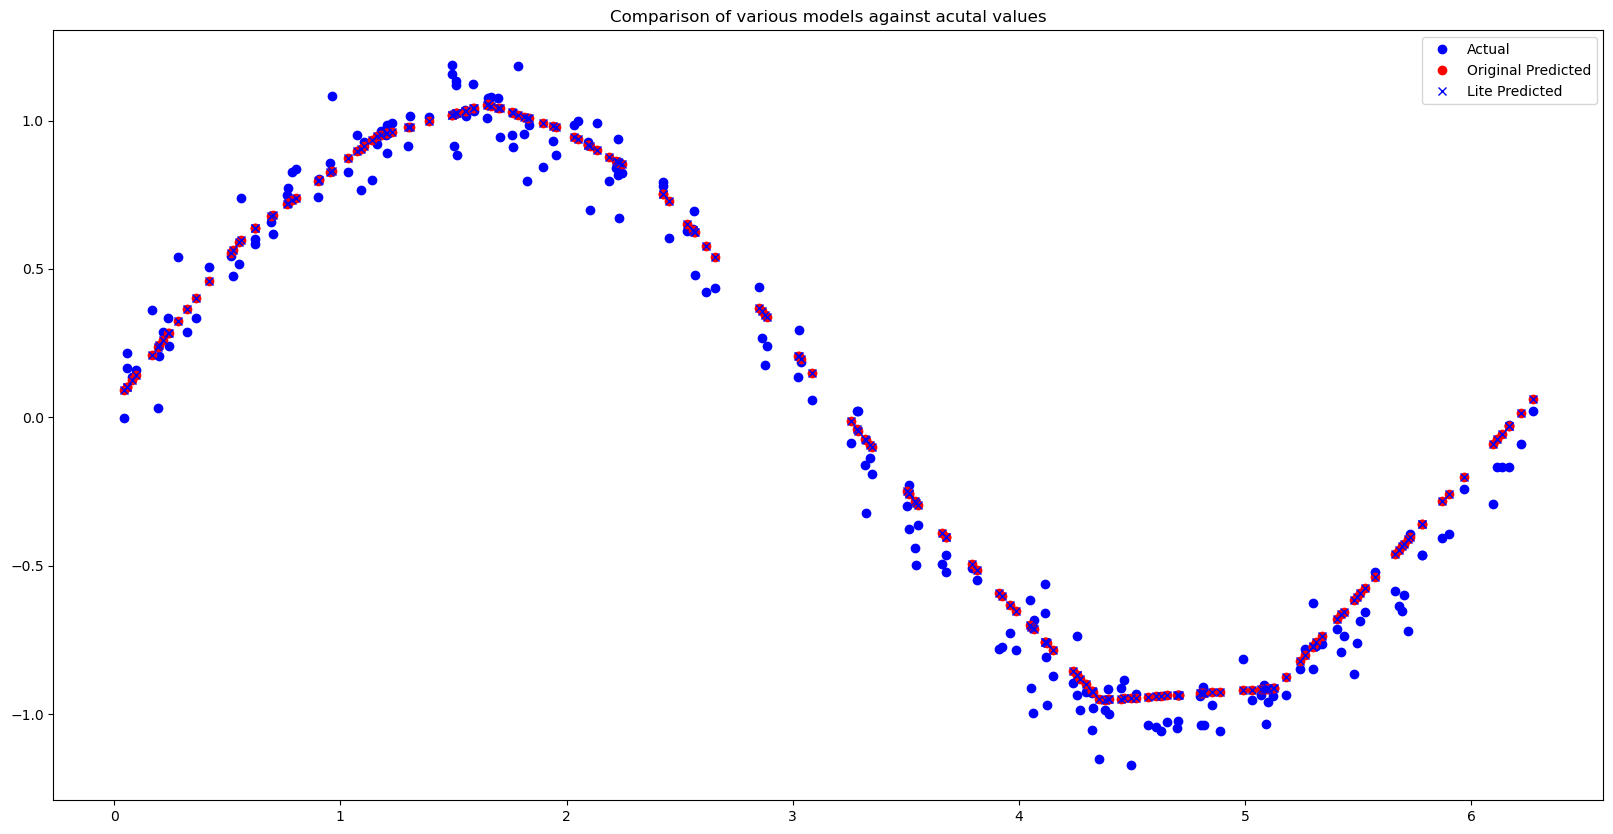

In [32]:
plt.clf()
plt.figure(figsize=(20,10))
plt.title('Comparison of various models against acutal values')
plt.plot(x_test, y_test, 'bo', label='Actual')
plt.plot(x_test, predictions, 'ro', label='Original Predicted')
plt.plot(x_test, sine_model_predictions, 'bx', label='Lite Predicted')
# plt.plot(x_test, sine_model_quantized_predictions, 'gx', label='Lite Quantized Predicted')
plt.legend()
plt.show()

Tras esto, lo siguiente es exportar el modelo en un archivo del lenguaje **C++** y mostrarlo; eso es así porque el Arduino IDE trabaja con el lenguaje C++.

In [ ]:
import os
basic_model_size = os.path.getsize("sine_model_2.tflite")
print("Basic model is %d bytes" % basic_model_size)
!apt-get -qq install xxd
!xxd -i sine_model.tflite > sine_model_2.cc
!cat sine_model_2.cc

## En Arduino IDE:

Una vez generado el archivo y mostrado esa lista grande de dígitos, debemos pasar al Arduino IDE, una vez instalada la librería *Harvard_TinyMLx*, Nos dirigimos a las pestañas superiores.

- File / Examples / Harvard_TinyMLx / hello_world

Se nos abriran una serie de archivos, que podremos visualizar en la parte superior del programa, nos dirigiremos al que tiene el nombre **model.cpp** y lo abriremos.

Para este punto te habrás dado cuenta de que los digitos que obtuvimos con el convertidor van en esta seccion, copialos y pegalos, reemplazando al modelo de prueba, así como tambien el último número generado en la parte anterior en cuál indica el tamaño en *bytes* del mismo.

Finalmente conecta la placa de arduino y sube el código al microcontrolador.


## De regreso a Python

Recordando que es necesario un entorno de desarrollo en Python, tenemos que utlizar uno localmente en la computadora para poder recibir los datos que el arduino está mandando como las predicciones. Para esto abre el archivo *Graficar funciones.py* que se encuentra en esta misma carpeta.

Cierra el Arduino IDE, no sin antes anotar el puerto COM al cual nos menciona que está conectado el arduino. (Para ver esto, selecciona el menú desplegable justo a un lado de los botones de compilar y subir en el IDE de Arduino y anota el puerto COM que se encuentra justo debajo de "Arduino Nano 33 BLE").

El código es una comunicación que toma los valores que provienen del arduino y los grafica, el código se encuentra también a continuación:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import serial
import time

data = []

# Reemplaza "COM5" con el puerto serie correspondiente a tu Arduino.
serialArduino = serial.Serial("COM5", 9600, timeout=1.0)
time.sleep(1)  # Espera 1 segundo para dar tiempo a conectarse

start_time = time.time()
while (time.time() - start_time) < 5:  # Leer datos durante 5 segundos
    try:
        cad = serialArduino.readline().decode('ascii').strip()
        data.append(float(cad))
    except ValueError:
        pass

serialArduino.close()

plt.plot(data)
plt.title('Datos de la función sinusoidal')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.show()

## Desafios:

Para afianzar lo aprendido, te ofrezco diferentes retos para que pruebes tu capacidad y tu entendimiento de los conceptos.

Reto 1: Puedes crear un modelo que pueda predecir una función diferente a la seno. Por ejemplo, la función coseno.

Reto 2: Puedes crear un modelo con una precisión mayor. Para ello, puedes probar a cambiar el número de neuronas, el número de capas, el número de épocas, el tamaño del batch, etc.

Reto 3: Crea un Notebook con una idea en la que se puede utilizar sensores, microcontroladores y TinyML. Puedes utilizar el ejemplo de la clase como base para tu idea.

Para crearlos y subirlos, crea un *fork* de este repositorio, añade tus archivos y crea un *pull request* para que pueda revisarlos, todos estos realizalos en la carpeta /Desafios.